In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE

In [112]:
df = pd.read_csv("E:/College Project/crime.csv", encoding="latin1")

In [113]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [114]:
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"], errors= "coerce")

In [115]:
df.isnull().sum()

INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64

In [116]:
df = df.dropna(subset=["Lat", "Long"])

In [117]:
for col in ["DISTRICT", "UCR_PART"]:
    df[col] = df[col].fillna("Unknown")

In [118]:
df = pd.get_dummies(df, columns=["DAY_OF_WEEK", "UCR_PART"], drop_first=True)
le = LabelEncoder()

df['DISTRICT'] = le.fit_transform(df['DISTRICT'])

In [119]:
print("Preprocessed Data:")
df.head()

Preprocessed Data:


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,DAY_OF_WEEK_Monday,DAY_OF_WEEK_Saturday,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,UCR_PART_Part One,UCR_PART_Part Three,UCR_PART_Part Two,UCR_PART_Unknown
0,I182070945,619,Larceny,LARCENY ALL OTHERS,7,808,NaN,2018-09-02 13:00:00,2018,9,...,False,False,True,False,False,False,True,False,False,False
1,I182070943,1402,Vandalism,VANDALISM,5,347,NaN,2018-08-21 00:00:00,2018,8,...,False,False,False,False,True,False,False,False,True,False
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,8,151,NaN,2018-09-03 19:27:00,2018,9,...,True,False,False,False,False,False,False,True,False,False
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,8,272,NaN,2018-09-03 21:16:00,2018,9,...,True,False,False,False,False,False,False,True,False,False
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,4,421,NaN,2018-09-03 21:05:00,2018,9,...,True,False,False,False,False,False,False,True,False,False


In [120]:
# Convert OCCURRED_ON_DATE to datetime
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"], errors="coerce")

# Extract date components before dropping the column
df["YEAR"] = df["OCCURRED_ON_DATE"].dt.year
df["MONTH"] = df["OCCURRED_ON_DATE"].dt.month
df["DAY"] = df["OCCURRED_ON_DATE"].dt.day
df["HOUR"] = df["OCCURRED_ON_DATE"].dt.hour

# Drop the original OCCURRED_ON_DATE column
df = df.drop(columns=["OCCURRED_ON_DATE"])

# Verify the extracted columns
print(df[["YEAR", "MONTH", "DAY", "HOUR"]].head())

   YEAR  MONTH  DAY  HOUR
0  2018      9    2    13
1  2018      8   21     0
2  2018      9    3    19
3  2018      9    3    21
4  2018      9    3    21


In [121]:
features = ["Lat", "Long", "YEAR", "MONTH", "HOUR", "DAY"]
features += [col for col in df.columns if "DISTRICT_" in col or "UCR_PART_" in col]  # Add encoded features
df_selected = df[features]

In [122]:
crime_counts = df.groupby(["Lat", "Long"]).size().reset_index(name="crime_count")
threshold = np.percentile(crime_counts["crime_count"], 80) 
crime_counts["hotspot"] = (crime_counts["crime_count"] >= threshold).astype(int)

In [123]:
df = df.merge(crime_counts[["Lat", "Long", "hotspot"]], on=["Lat", "Long"], how="left")

In [124]:
df.describe()

,OFFENSE_CODE,DISTRICT,YEAR,MONTH,HOUR,Lat,Long,DAY,hotspot
count,299074.000000,299074.000000,299074.000000,299074.000000,299074.000000,299074.000000,299074.000000,299074.000000,299074.000000
mean,2296.498489,5.202652,2016.554318,6.613999,13.123013,42.214381,-70.908272,15.739807,0.714793
std,1182.934237,3.107849,1.000259,3.277442,6.280145,2.159766,3.493618,8.839110,0.451514
min,111.000000,0.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674,1.000000,0.000000
25%,802.000000,3.000000,2016.000000,4.000000,9.000000,42.297442,-71.097135,8.000000,0.000000
50%,2907.000000,5.000000,2017.000000,7.000000,14.000000,42.325538,-71.077524,16.000000,1.000000
75%,3201.000000,8.000000,2017.000000,9.000000,18.000000,42.348624,-71.062467,23.000000,1.000000
max,3831.000000,12.000000,2018.000000,12.000000,23.000000,42.395042,-1.000000,31.000000,1.000000


In [125]:
print("Final Processed Data for Model Training:")
print(df.head())

Final Processed Data for Model Training:
  INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

   DISTRICT REPORTING_AREA SHOOTING  YEAR  MONTH  HOUR  ...  \
0         7            808      NaN  2018      9    13  ...   
1         5            347      NaN  2018      8     0  ...   
2         8            151      NaN  2018      9    19  ...   
3         8            272      NaN  2018      9    21  ...   
4         4            421      NaN  2018      9    21  ...   

  DAY_OF_WEEK_Sunday  DAY_OF_WEEK_Thursday  DAY_OF_WEEK_Tuesday  \
0               True                 F

In [126]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [127]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numeric
    label_encoders[col] = le  # Store the encoders for later use



# # Loop through all label encoders and save their mappings
# for col, le in label_encoders.items():
#     # Create a DataFrame for the mapping
#     mapping_df = pd.DataFrame({
#         col: le.classes_,  # Original categorical values
#         "ENCODED_VALUE": range(len(le.classes_))  # Encoded values
#     })
    
#     # Save the mapping to a CSV file
#     mapping_df.to_csv(f"{col}_label_mapping.csv", index=False)
#     print(f"Mapping for column '{col}' has been saved to '{col}_label_mapping.csv'")

In [128]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,HOUR,...,DAY_OF_WEEK_Sunday,DAY_OF_WEEK_Thursday,DAY_OF_WEEK_Tuesday,DAY_OF_WEEK_Wednesday,UCR_PART_Part One,UCR_PART_Part Three,UCR_PART_Part Two,UCR_PART_Unknown,DAY,hotspot
0,265312,619,34,128,7,784,1,2018,9,13,...,True,False,False,False,True,False,False,False,2,0
1,265311,1402,63,225,5,275,1,2018,8,0,...,False,False,True,False,False,False,True,False,21,1
2,265310,3410,62,217,8,60,1,2018,9,19,...,False,False,False,False,False,True,False,False,3,0
3,265309,3114,32,122,8,192,1,2018,9,21,...,False,False,False,False,False,True,False,False,3,0
4,265308,3114,32,122,4,357,1,2018,9,21,...,False,False,False,False,False,True,False,False,3,0


In [129]:
# Split features and target variable
X = df.drop(columns=["hotspot"])
y = df["hotspot"]

In [131]:
# Drop low-correlation and redundant features
features_to_drop = [
    "INCIDENT_NUMBER", "OFFENSE_CODE", "OFFENSE_CODE_GROUP", "REPORTING_AREA",
    "SHOOTING", "DAY_OF_WEEK_Monday", "DAY_OF_WEEK_Saturday",
    "DAY_OF_WEEK_Sunday", "DAY_OF_WEEK_Thursday", "DAY_OF_WEEK_Tuesday",
    "DAY_OF_WEEK_Wednesday", "UCR_PART_Part Three"
]

# Ensure only existing columns are dropped
features_to_drop = [col for col in features_to_drop if col in X.columns]
X = X.drop(columns=features_to_drop)
print("Remaining features after removal:", X.columns.tolist())

Remaining features after removal: ['OFFENSE_DESCRIPTION', 'DISTRICT', 'YEAR', 'MONTH', 'HOUR', 'STREET', 'Lat', 'Long', 'Location', 'UCR_PART_Part One', 'UCR_PART_Part Two', 'UCR_PART_Unknown', 'DAY']


In [132]:
# Check the number of input features
print(f"Number of input features: {X.shape[1]}")

# Display the names of input features
print("Input feature names:", X.columns.tolist())

Number of input features: 13
Input feature names: ['OFFENSE_DESCRIPTION', 'DISTRICT', 'YEAR', 'MONTH', 'HOUR', 'STREET', 'Lat', 'Long', 'Location', 'UCR_PART_Part One', 'UCR_PART_Part Two', 'UCR_PART_Unknown', 'DAY']


In [22]:
# X["year"] = X["OCCURRED_ON_DATE"].dt.year
# X["month"] = X["OCCURRED_ON_DATE"].dt.month
# X["day"] = X["OCCURRED_ON_DATE"].dt.day
# X["hour"] = X["OCCURRED_ON_DATE"].dt.hour  # If time is relevant

# # X_test["year"] = X_test["OCCURRED_ON_DATE"].dt.year
# # X_test["month"] = X_test["OCCURRED_ON_DATE"].dt.month
# # X_test["day"] = X_test["OCCURRED_ON_DATE"].dt.day
# # X_test["hour"] = X_test["OCCURRED_ON_DATE"].dt.hour  # If time is relevant

# # Now drop the original datetime column
# X = X.drop(columns=["OCCURRED_ON_DATE"])
# # X_test = X_test.drop(columns=["OCCURRED_ON_DATE"])


In [133]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
hotspot
0    213776
1    213776
Name: count, dtype: int64


In [134]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# X_train.to_csv("X_train.csv", index=False)

# print("X_train has been saved to 'X_train.csv'")

X_train has been saved to 'X_train.csv'


In [136]:
model = RandomForestClassifier(max_depth=15, min_samples_split=2, 
    min_samples_leaf=4, n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=50,
                       random_state=42)

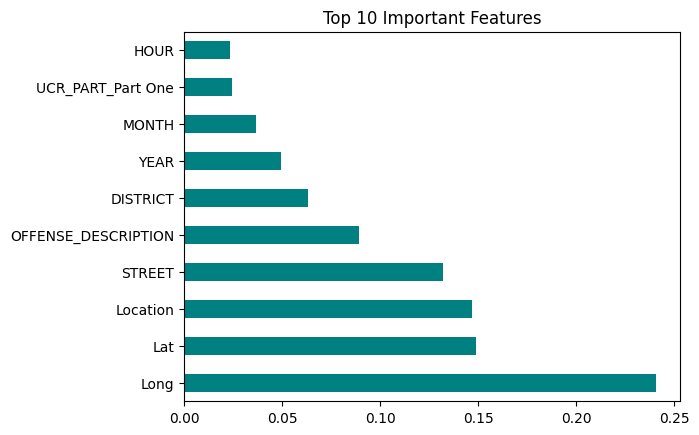

In [137]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Important Features")
plt.show()

In [138]:
y_pred = model.predict(X_test)

In [139]:
X_train.shape,X_test.shape

((342041, 13), (85511, 13))

In [140]:
print("Model Accuracy:", accuracy_score(y_test, y_pred)*100)
print("r2_score:", r2_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 82.41980563904059
r2_score: 0.2967921654553578
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82     42768
           1       0.81      0.85      0.83     42743

    accuracy                           0.82     85511
   macro avg       0.83      0.82      0.82     85511
weighted avg       0.83      0.82      0.82     85511



In [141]:
print(f"Training Accuracy: {model.score(X_train, y_train)}")
print(f"Validation Accuracy: {model.score(X_test, y_test)}")

Training Accuracy: 0.8452495461070456
Validation Accuracy: 0.8241980563904059


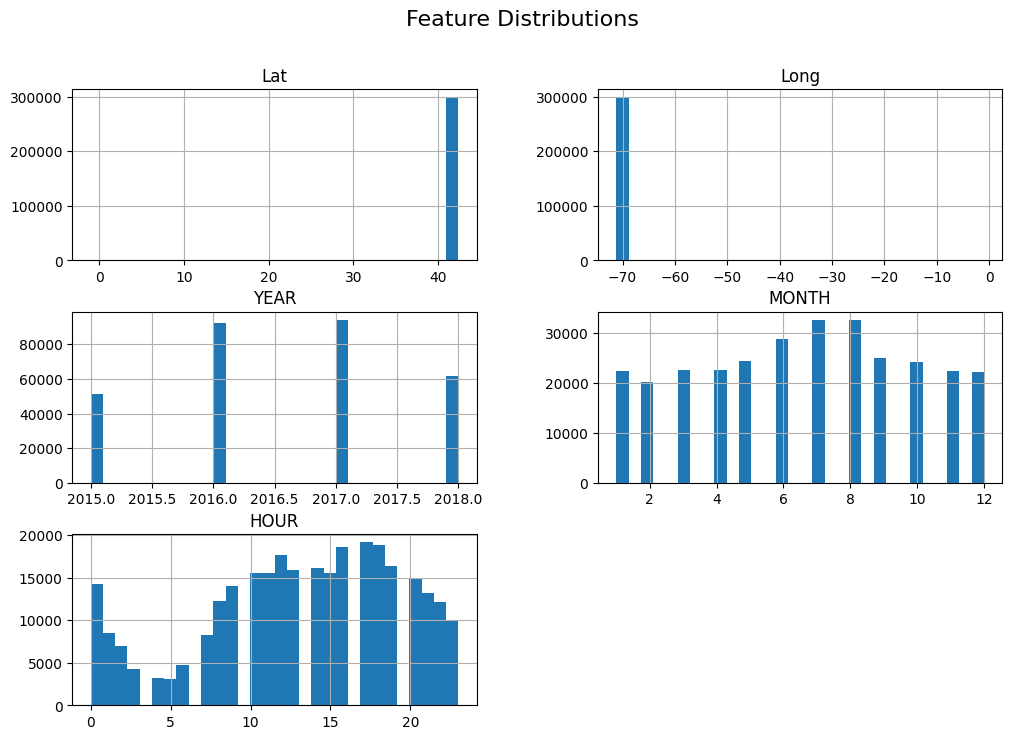

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical features to plot
num_features = ["Lat", "Long", "YEAR", "MONTH", "HOUR"]

# Plot histograms
df[num_features].hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

C:\Users\mbnss\AppData\Local\Temp\ipykernel_22052\2312626124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["HOUR"], palette="viridis")


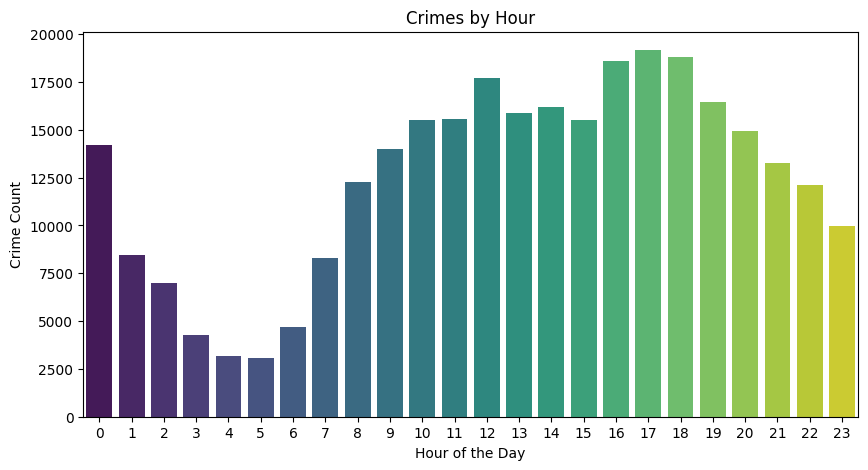

In [143]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["HOUR"], palette="viridis")
plt.xlabel("Hour of the Day")
plt.ylabel("Crime Count")
plt.title("Crimes by Hour")
plt.show()

In [164]:
test_inputs = np.array([
    [6, 5, 765, 20, 71.7825, -31.7628, 9800, 0, 1, 0, 8, 12, 2024],  # Low-crime location & features

    [42.3601, -71.0589, 2023, 5, 15, 10, 2, 0, 0, 0, 0, 0, 0],    

    [34.0522, -118.2437, 2023, 7, 20, 22, 5, 1, 0, 1, 0, 0, 0],

    [40.7128, -74.0060, 2024, 3, 10, 14, 3, 0, 0, 0, 0, 0, 0],

    [51.5074, -0.1278, 2024, 12, 25, 23, 7, 1, 1, 0, 0, 0, 1],

    [42.3601, -71.0589, 2023, 2, 10, 5, 0, 0, 0, 0, 0, 0, 0],

    [40.7128, -74.0060, 2024, 1, 15, 4, 0, 0, 0, 0, 0, 0, 0],

    # [254, 20220412, 22, 765, 40.7128, -74.0060, 50000, 0, 1, 0, 0, 1, 0, 0],
])
# Make predictions
predictions = model.predict(test_inputs)

# Print results
for i, pred in enumerate(predictions):
    print(f"Predicted Crime Category for Test Input {i+1}: {pred}")

Predicted Crime Category for Test Input 1: 0
Predicted Crime Category for Test Input 2: 1
Predicted Crime Category for Test Input 3: 1
Predicted Crime Category for Test Input 4: 1
Predicted Crime Category for Test Input 5: 1
Predicted Crime Category for Test Input 6: 1
Predicted Crime Category for Test Input 7: 1


c:\Users\mbnss\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [151]:
# After dropping unnecessary features and finalizing X
X = X.drop(columns=[col for col in features_to_drop if col in X.columns])

# Print the number of features and their names
print(f"Number of input features: {X.shape[1]}")
print("Input feature names:", X.columns.tolist())

Number of input features: 13
Input feature names: ['OFFENSE_DESCRIPTION', 'DISTRICT', 'YEAR', 'MONTH', 'HOUR', 'STREET', 'Lat', 'Long', 'Location', 'UCR_PART_Part One', 'UCR_PART_Part Two', 'UCR_PART_Unknown', 'DAY']


In [152]:
# import folium
# from folium.plugins import HeatMap

# # Create a map centered at an average location
# m = folium.Map(location=[df["Lat"].mean(), df["Long"].mean()], zoom_start=10)

# # Add heatmap layer
# heat_data = df[["Lat", "Long"]].values.tolist()
# HeatMap(heat_data).add_to(m)

# # Display map
# m

In [153]:
# Check class distribution in the target variable
print("Class distribution in the target variable:")
print(y_resampled.value_counts())

Class distribution in the target variable:
hotspot
0    213776
1    213776
Name: count, dtype: int64


In [154]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[34101  8667]
 [ 6366 36377]]


In [155]:
print("Input feature names:", X_train.columns.tolist())

Input feature names: ['OFFENSE_DESCRIPTION', 'DISTRICT', 'YEAR', 'MONTH', 'HOUR', 'STREET', 'Lat', 'Long', 'Location', 'UCR_PART_Part One', 'UCR_PART_Part Two', 'UCR_PART_Unknown', 'DAY']


In [156]:
import pickle

# Save the model
with open("model1.pkl", "wb") as model_file:
    pickle.dump(model, model_file)